In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import json
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from einops import repeat
from models.cvae import CVAEv1, CVAEv2

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
model_type = 'cvae' # 'cvae'
fname = 'v5'
split = 'system'

In [3]:
# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/recons_loss_list.pkl", 'rb') as f: # load dataset
    recons_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/kld_loss_list.pkl", 'rb') as f: # load dataset
    kld_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

/tmp/ipykernel_273703/1524880275.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.1*train_loss_list[0])


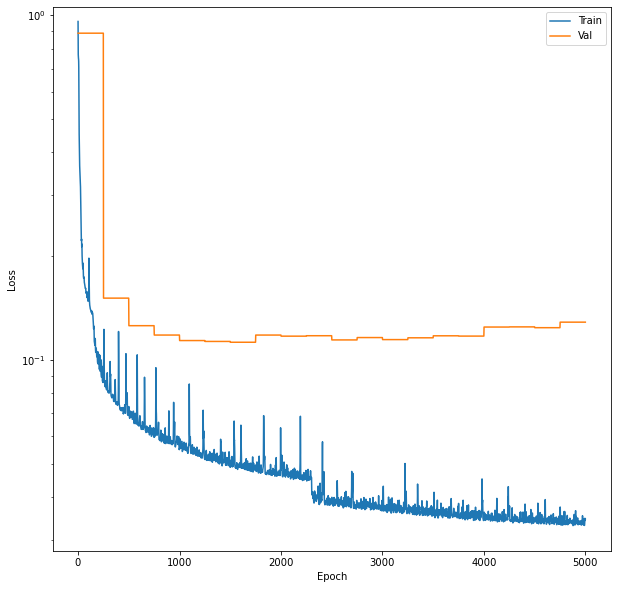

In [4]:
# Train/val loss fig
plt.figure(figsize=(10,10))
plt.plot(range(len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(len(val_loss_list)), val_loss_list, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0,1.1*train_loss_list[0])
plt.show()

In [5]:
# Load model
# model = CVAEv1(**configs['model_params'])
model = CVAEv2(**configs['model_params'])

model.load_state_dict(torch.load(f'runs/{model_type}/{split}/{fname}/best_model.pt', map_location=configs['device']))
model = model.to(configs['device'])
model.eval()

# Load test set
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
_, _, test_dataset = dataset.train_val_test_split(mode=split, both_graph_feat_present=True, random_state=0) # Note, here we filter out points with no graph/feature present for either zeolite and OSDA

# Get test zeolites and OSDAs
zeo_code, zeo, osda_smiles, osda, = test_dataset[3], test_dataset[5], test_dataset[13], test_dataset[15], 

# Predict synthesis conditions
zeo_code = repeat(np.array(zeo_code), 'n -> (repeat n)', repeat = 50)
zeo = repeat(zeo, 'n d -> (repeat n) d', repeat = 50)
osda_smiles = repeat(np.array(osda_smiles), 'n -> (repeat n)', repeat = 50)
osda = repeat(osda, 'n d -> (repeat n) d', repeat = 50)
zeo, osda = zeo.to(configs['device']), osda.to(configs['device'])
syn_pred = torch.tensor(model.predict(zeo, osda).cpu().detach().numpy())

# Scale synthesis conditions back
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_pred[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_pred[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_pred = pd.DataFrame(syn_pred, columns=dataset.ratio_names+dataset.cond_names)
syn_pred['zeo'], syn_pred['osda'] = zeo_code, osda_smiles
syn_pred.to_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv', index=False) # Save synthetic predictions
syn_pred.shape

SYSTEMS:
train: 1624 val: 232 test: 464

n_datapoints:
train: 14788 val: 2068 test: 5168


(258400, 14)

In [6]:
# Get ground truth
syn_true, zeo_code, osda_smiles = test_dataset[1], test_dataset[3], test_dataset[13]
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_true[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_true[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true['zeo'], syn_true['osda'] = zeo_code, osda_smiles
syn_true.shape

(5168, 14)

# Aggregated

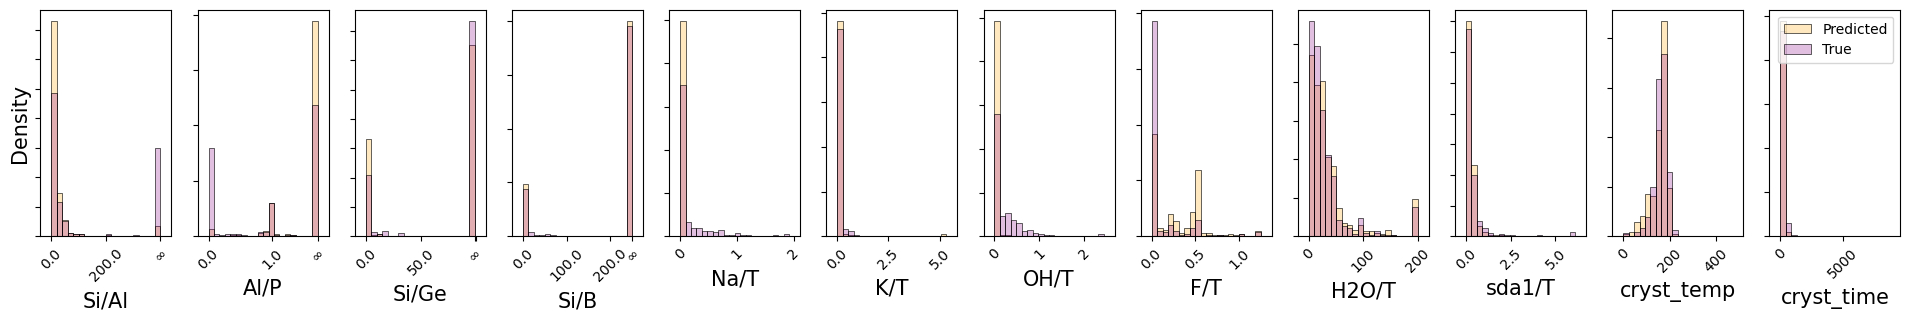

In [7]:
utils.compare_gel_conds([syn_pred, syn_true], ['Predicted', 'True'], ['orange', 'darkmagenta'], kde=False, common_norm=True, alpha=0.25)

# System

CHA C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


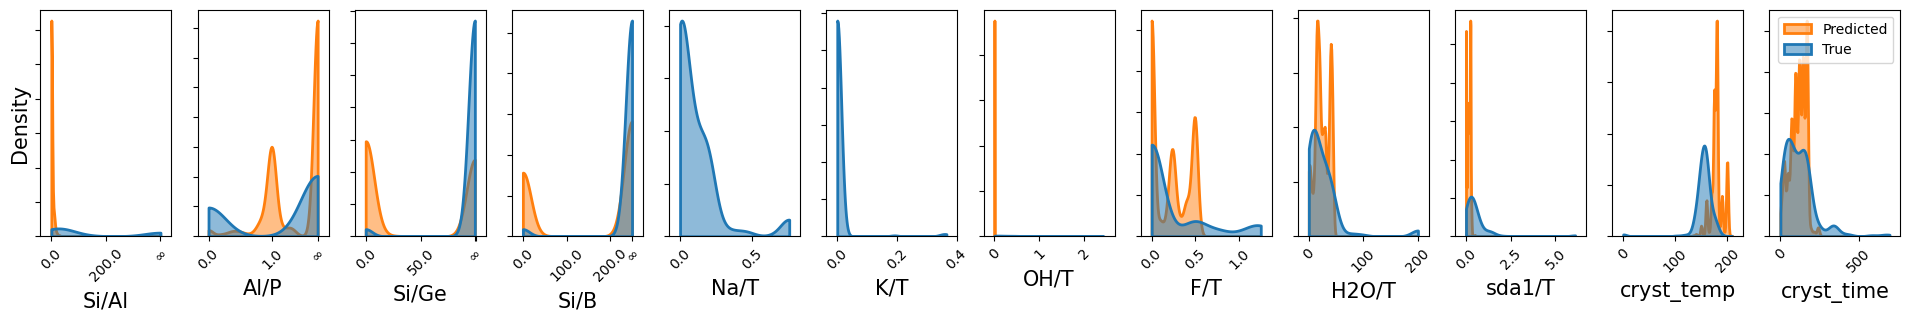

AEL CCCNCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


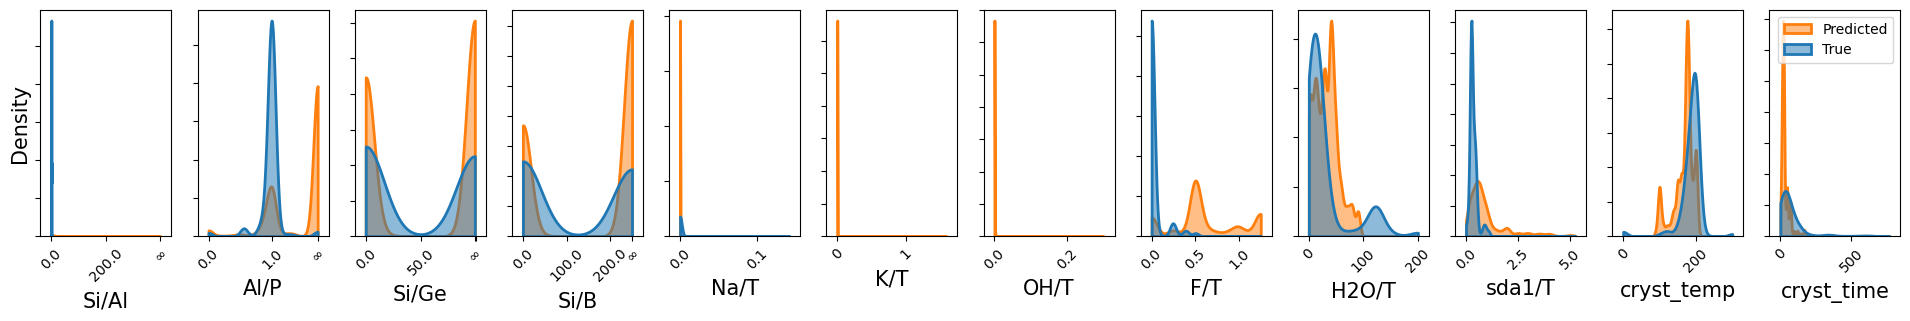

CHA OSDA-free


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


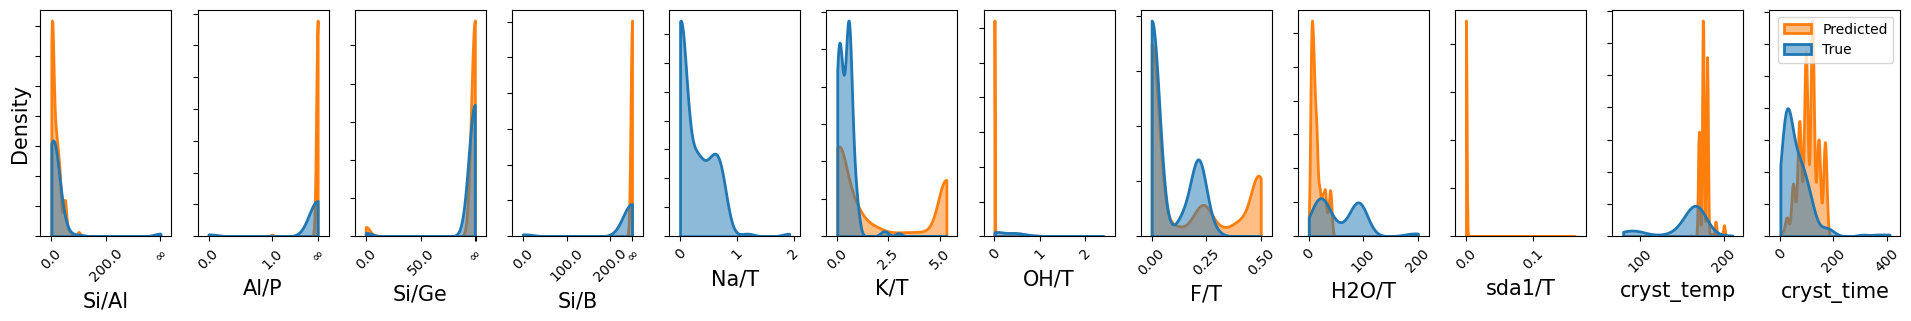

MFI OSDA-free


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

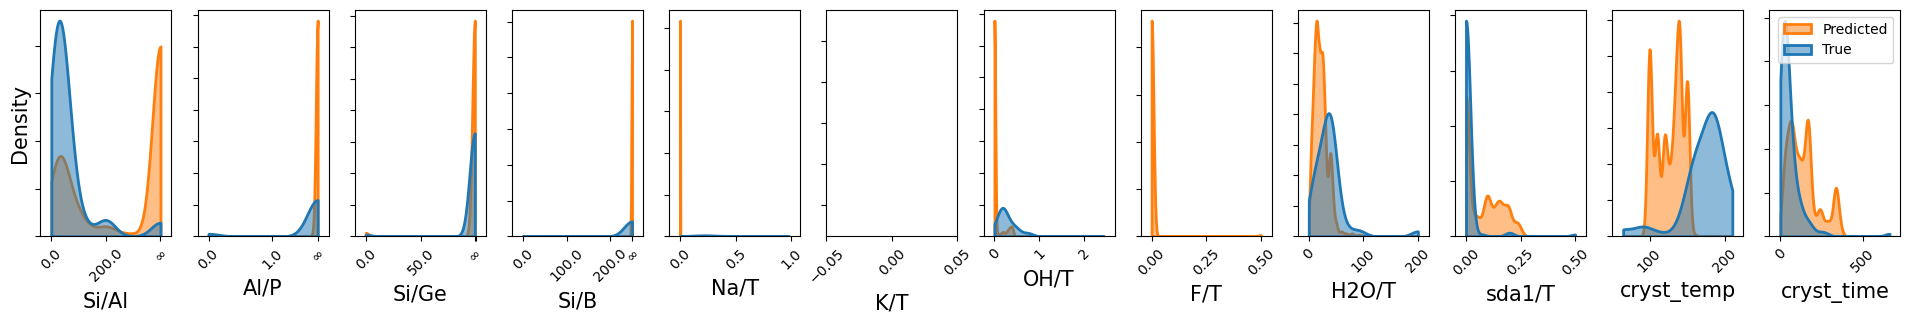

CHA CCN(CC)CC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, 

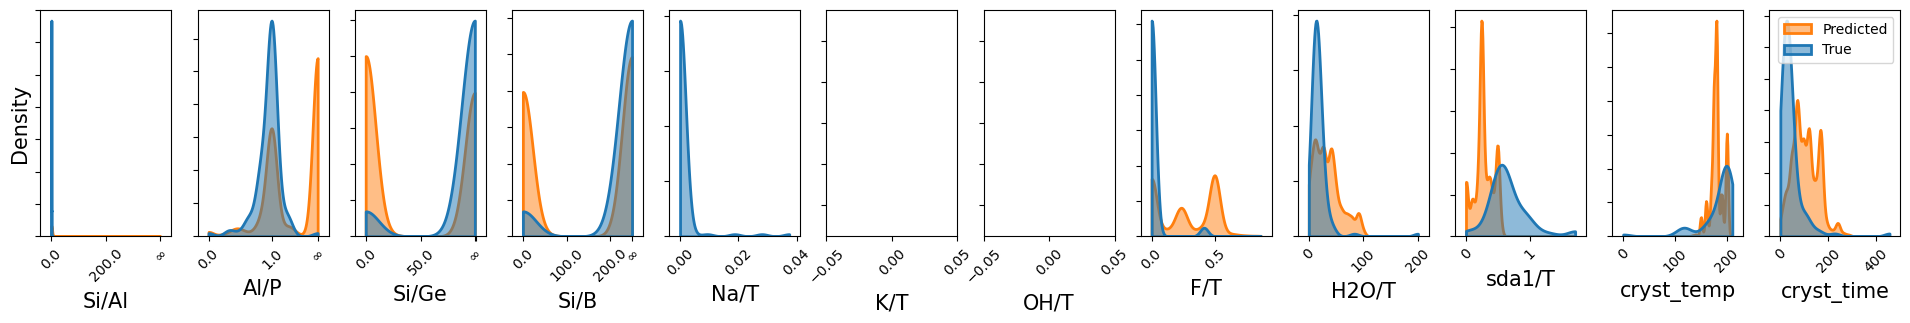

MEL CCCC[N+](CCCC)(CCCC)CCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


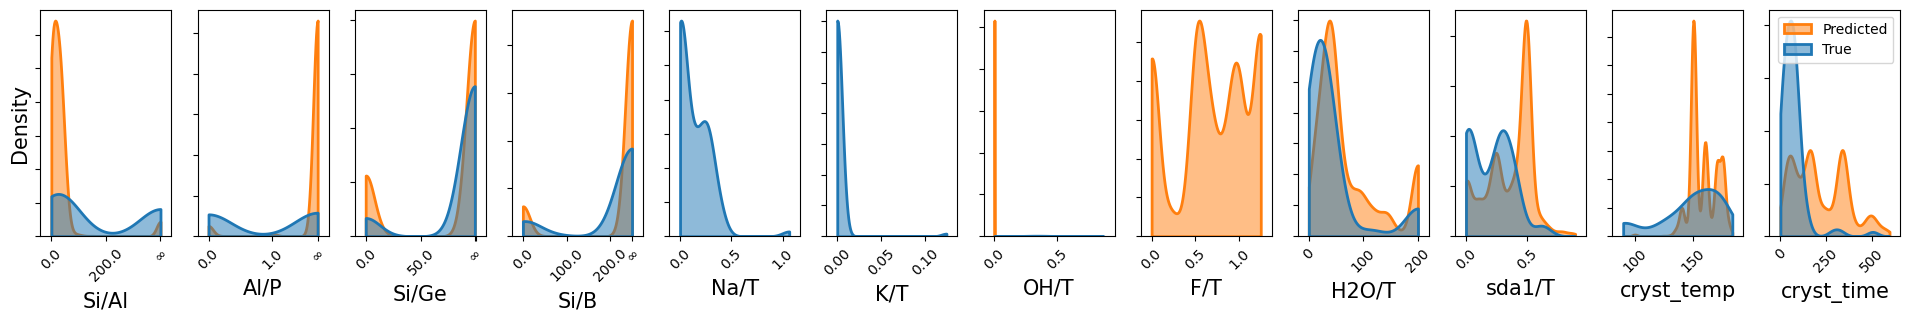

CHA C1COCCN1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

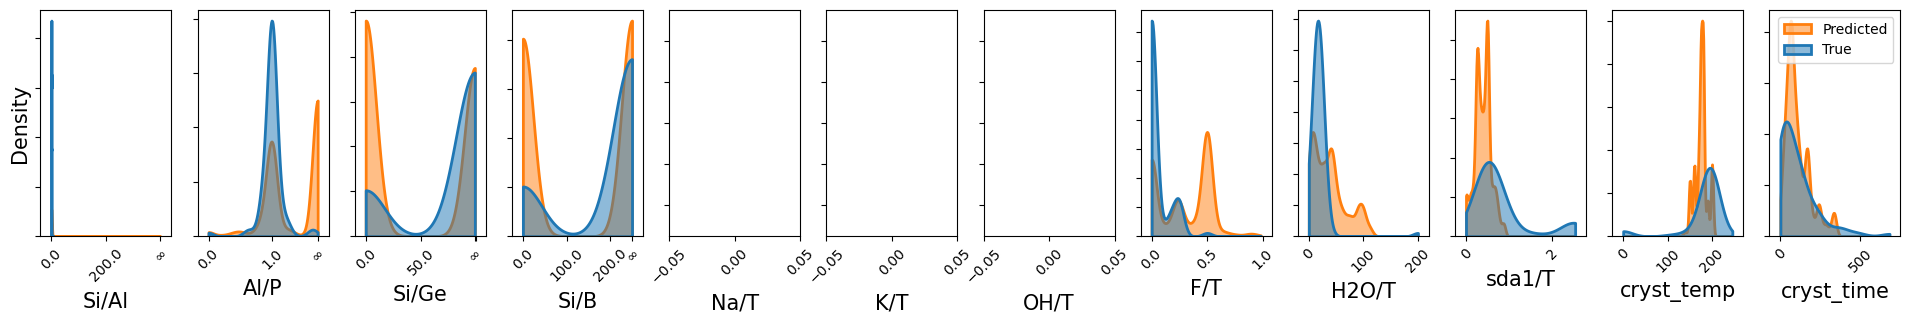

ATO CCCNCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

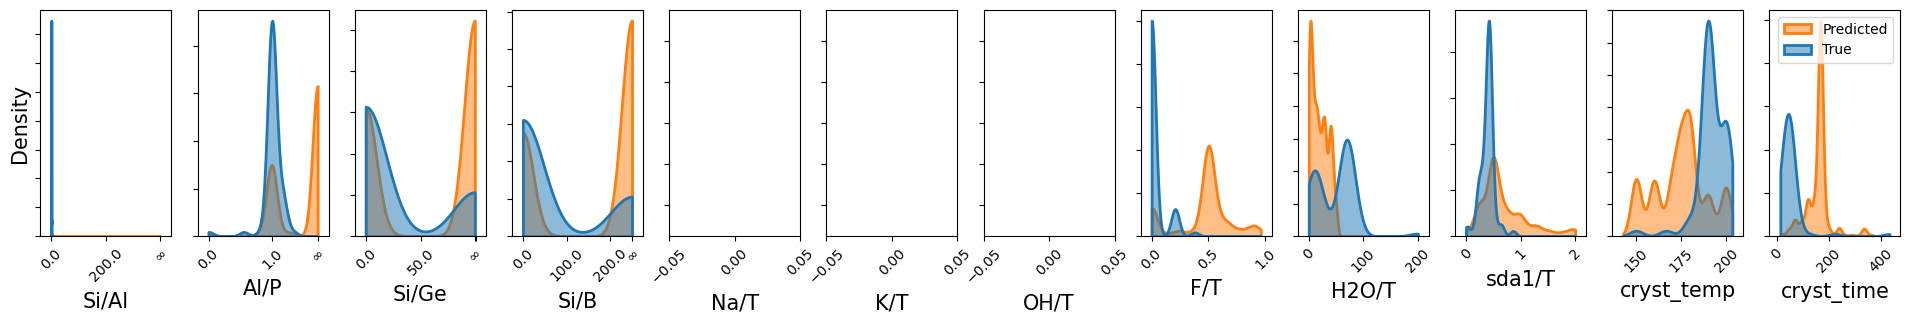

AEI CC1CC(C)C[N+](C)(C)C1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, 

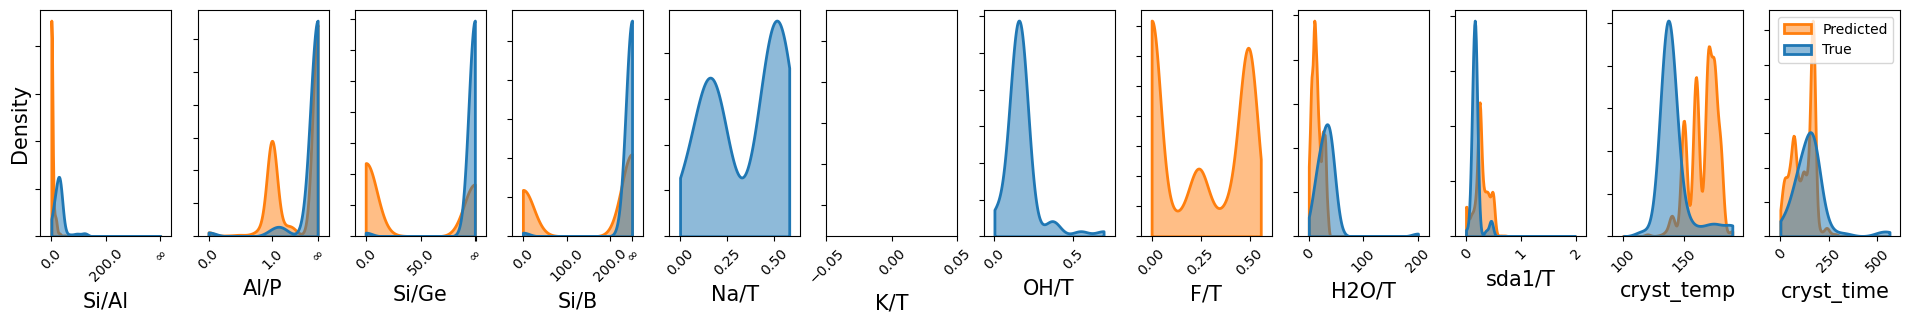

IMF C[N+]1(CCCCC[N+]2(C)CCCC2)CCCC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

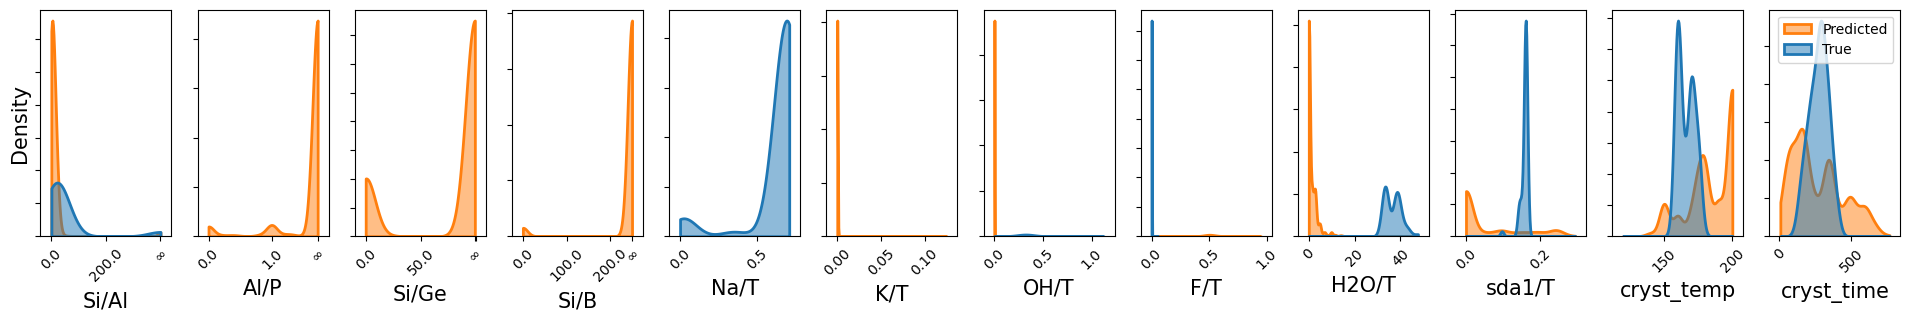

IWR CC[N+]1(CC)CC2C3C(C)=CC(C)(C2C1)C1C[N+](CC)(CC)CC31


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

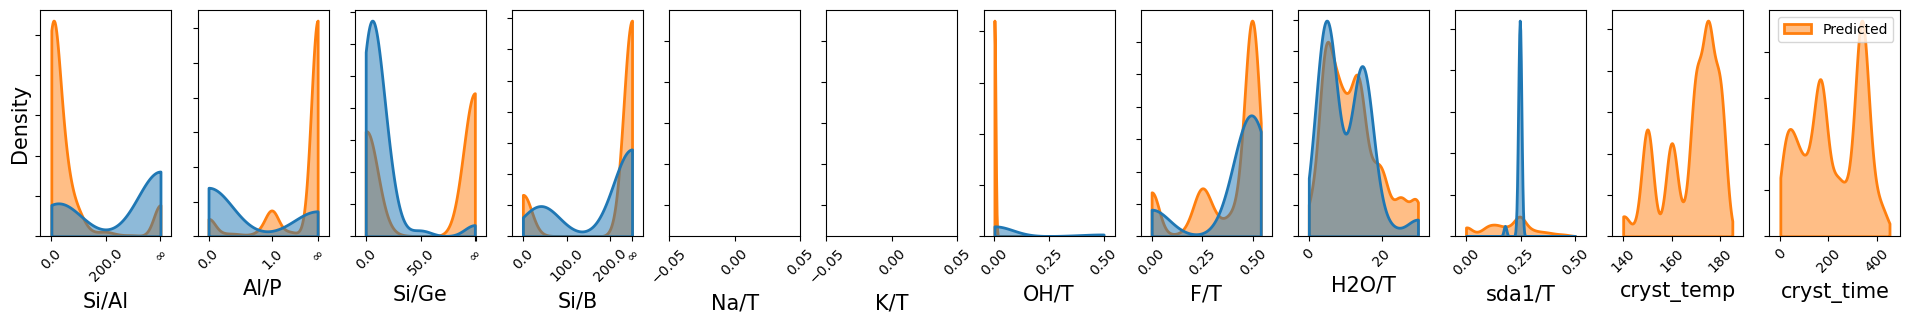

EMT C1COCCOCCOCCOCCOCCO1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


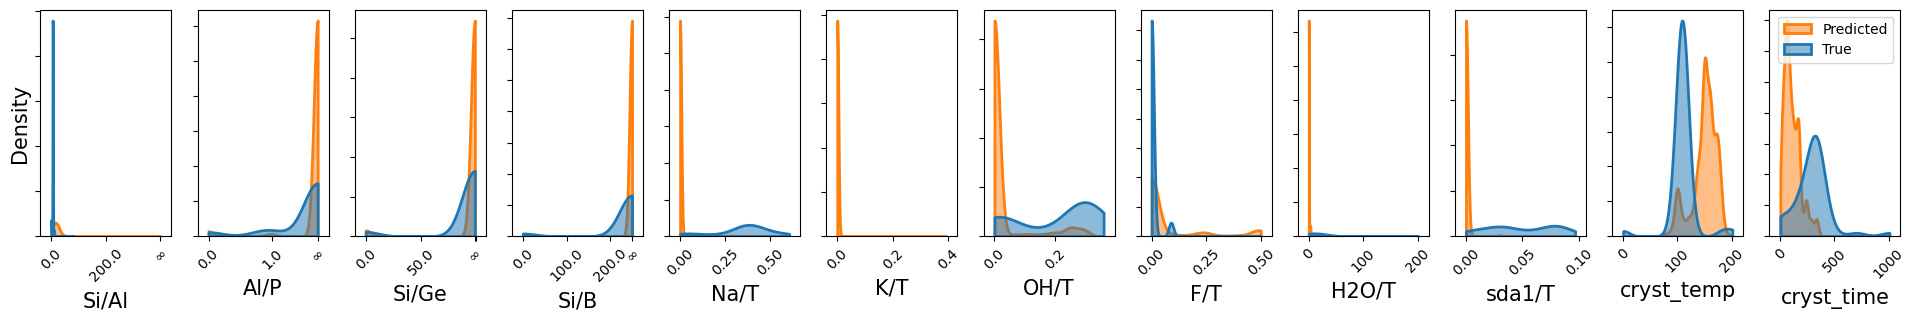

CHA CCNCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

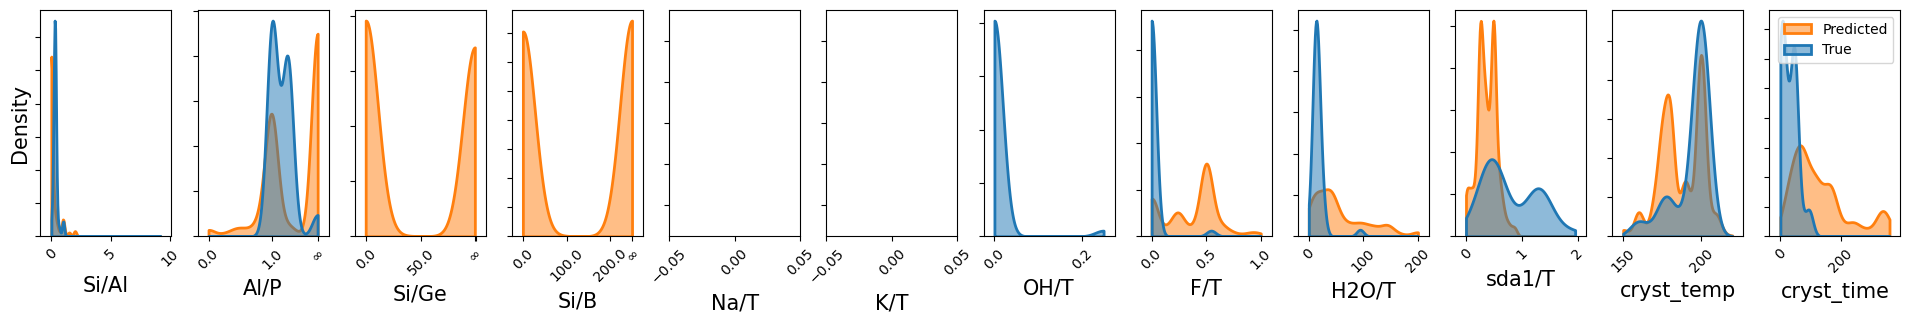

SFO CN(C)c1ccncc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

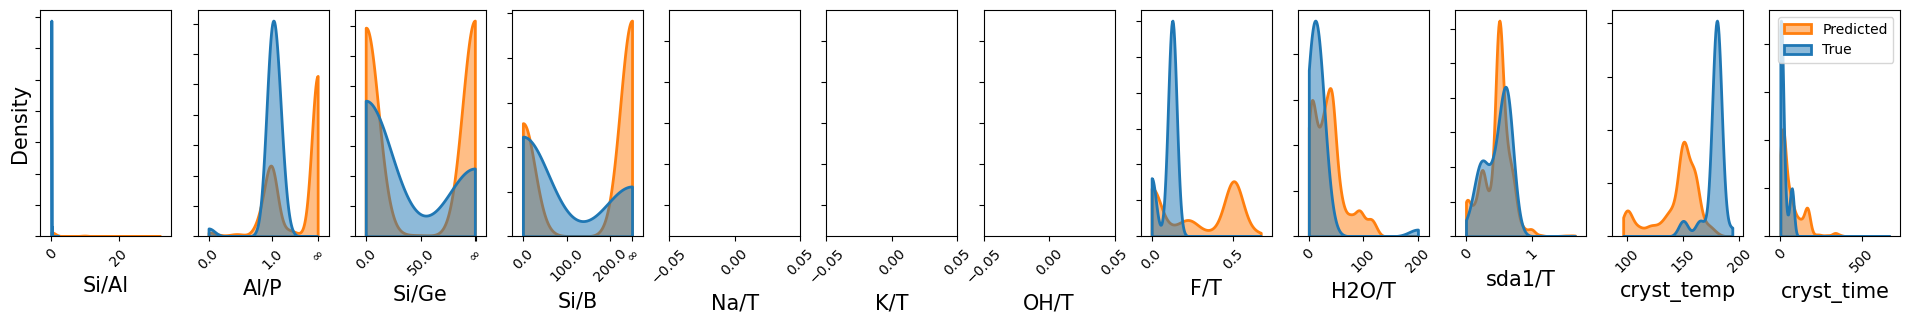

AFI C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

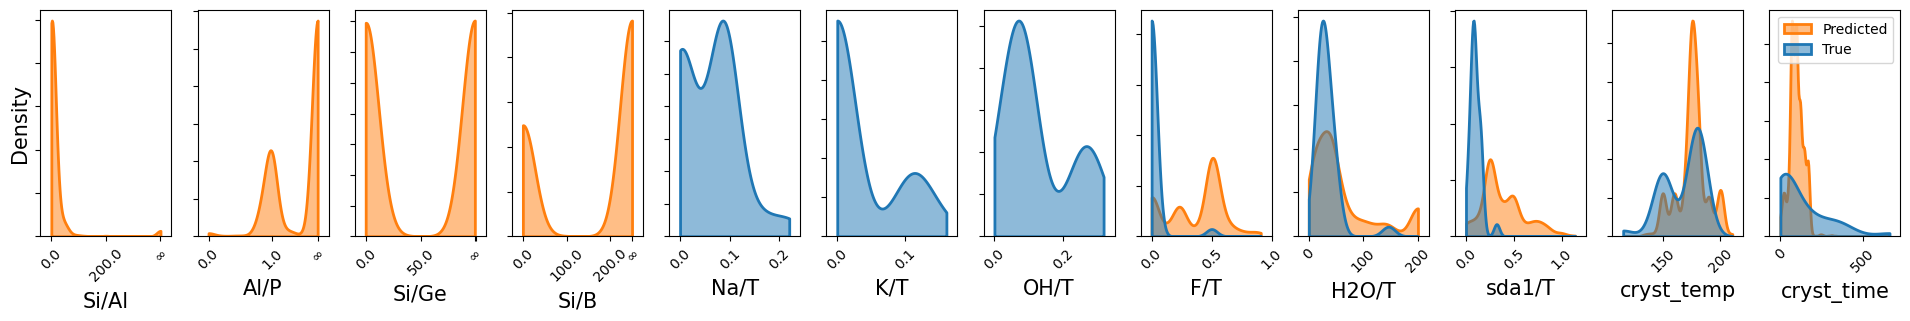

UTL C[C@H]1CCC[C@@H](C)[N+]12CCCC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

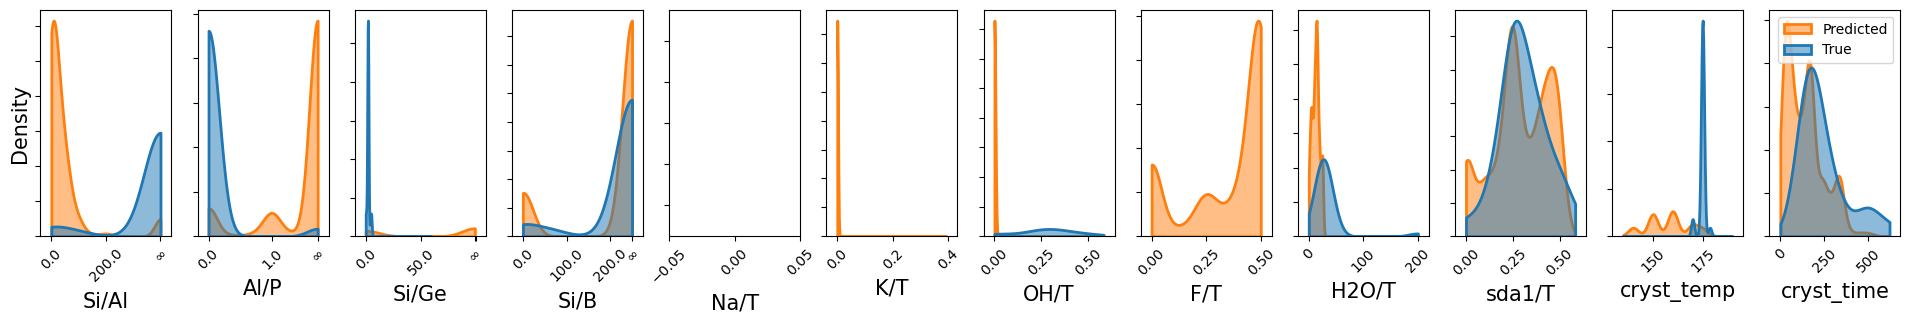

In [8]:
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in zeo_osda_systems:
# for zeo, osda in reversed(zeo_osda_systems):
    if zeo != 'Dense/Amorphous':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], ['tab:orange', 'tab:blue'], kde=True, common_norm=True, alpha=0.5, show_hist=False)
        
        count += 1
    if count > 15:
        break

# BEC systems

BEC c1ccc(C[N+]23CCC(CC2)CC3)cc1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


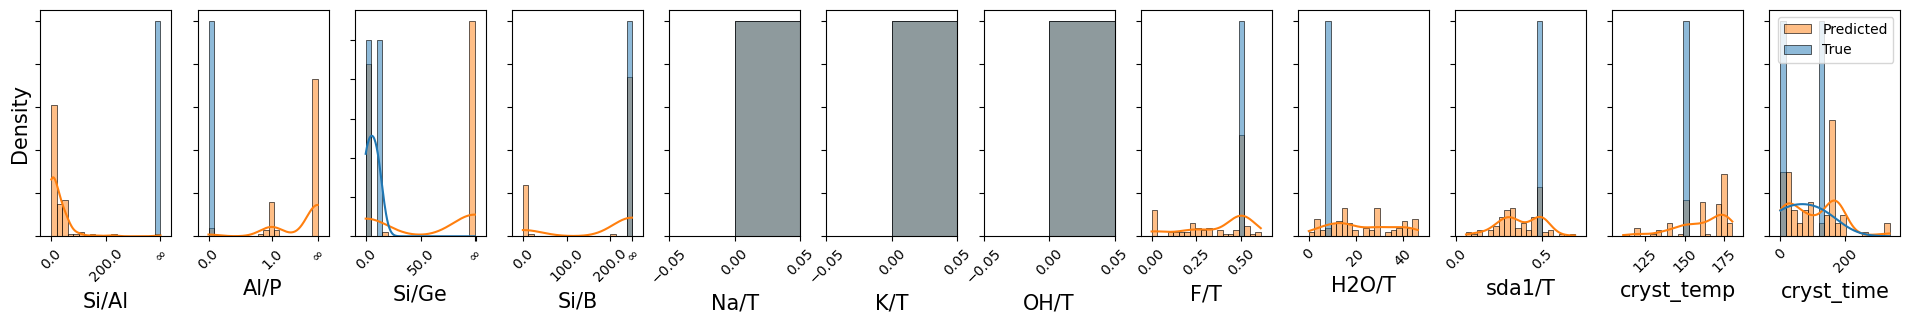

BEC c1cc(C[N+]23CCC(CC2)CC3)ccc1C[N+]12CCC(CC1)CC2


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


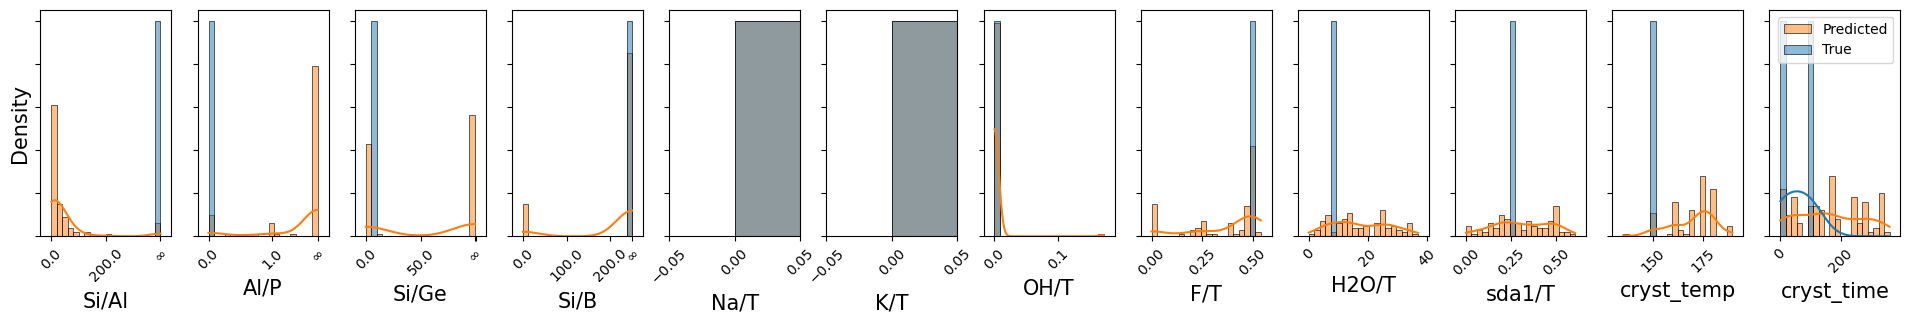

BEC C(CC[N+]12CCN(CC1)CC2)C[N+]12CCN(CC1)CC2


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


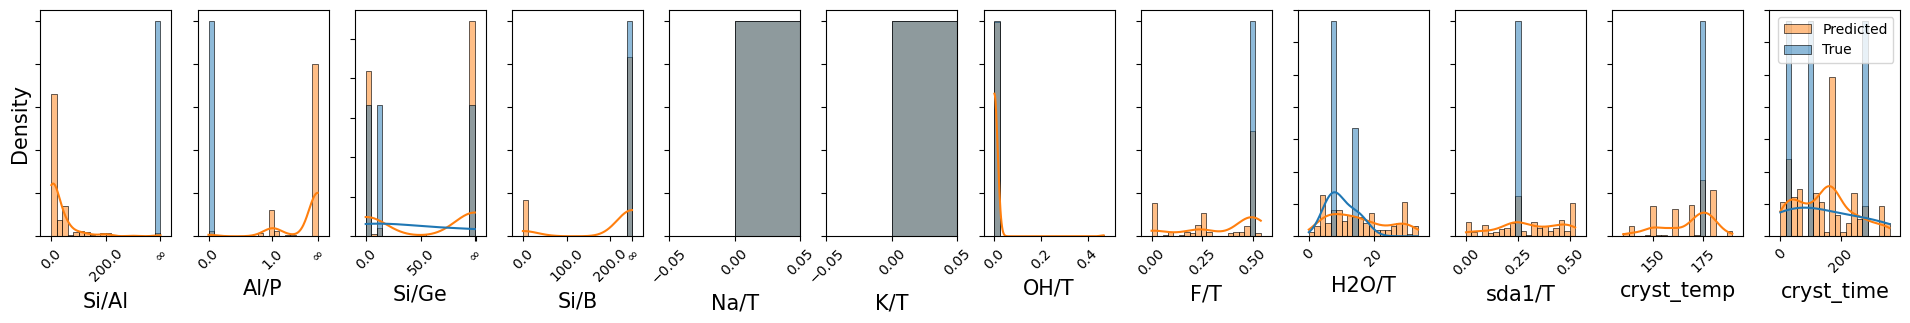

BEC CN(C)CCN(C)C


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


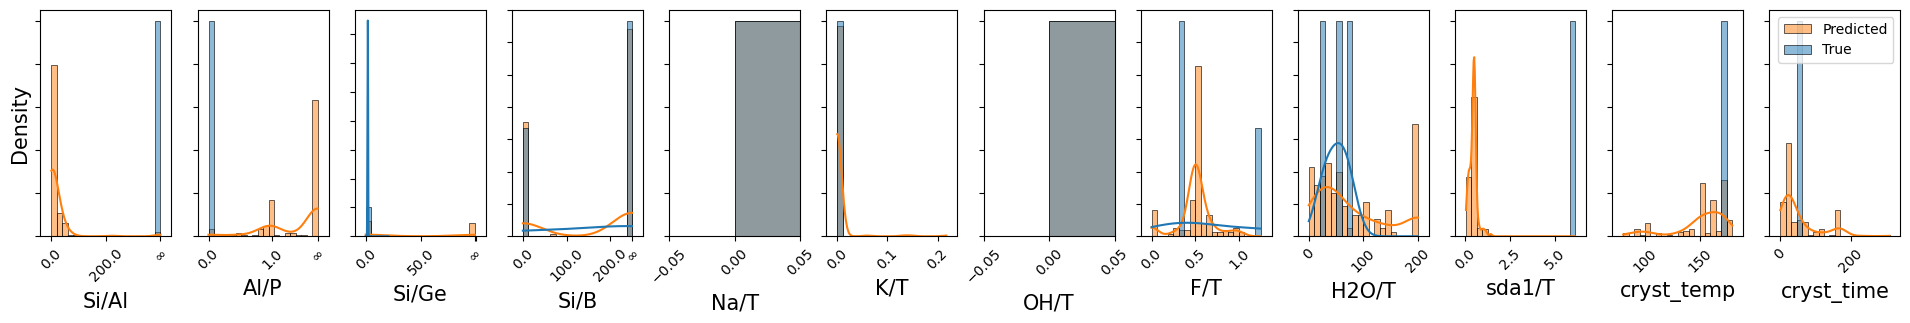

BEC CCC[N+]1(CCC)CCC([N+]2(CCC)CCCC2)CC1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


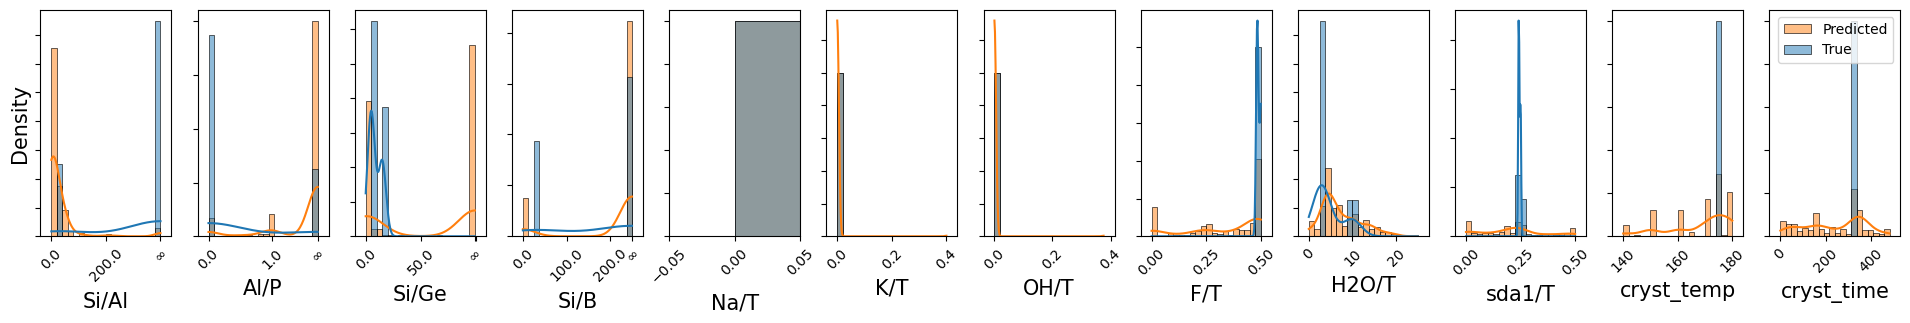

BEC c1ccc(C[N+]23CCN(CC2)CC3)cc1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


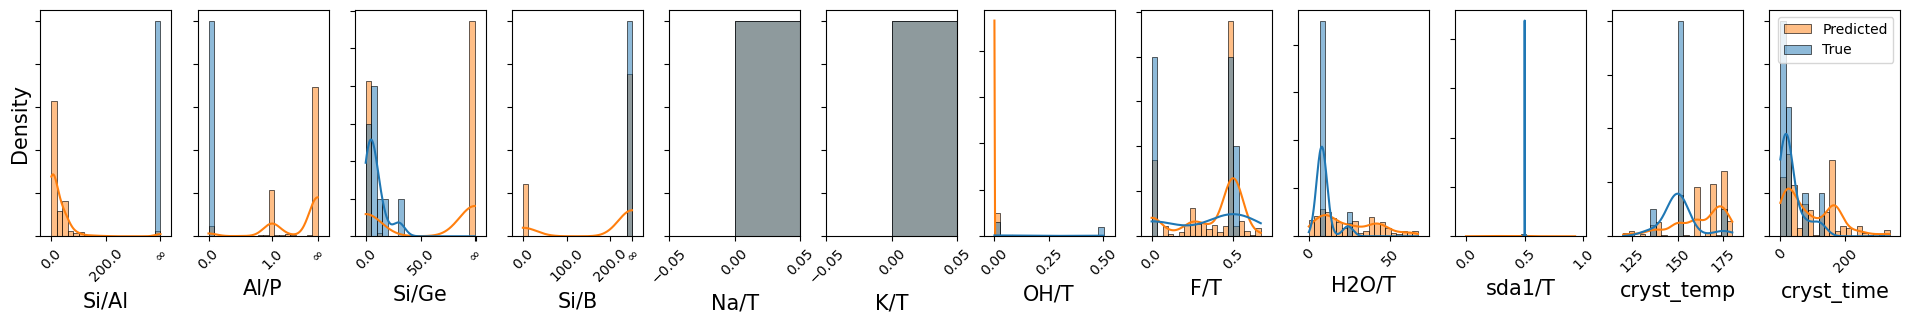

BEC C[N+]1(C)CCC([N+]2(C)CCCC2)CC1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


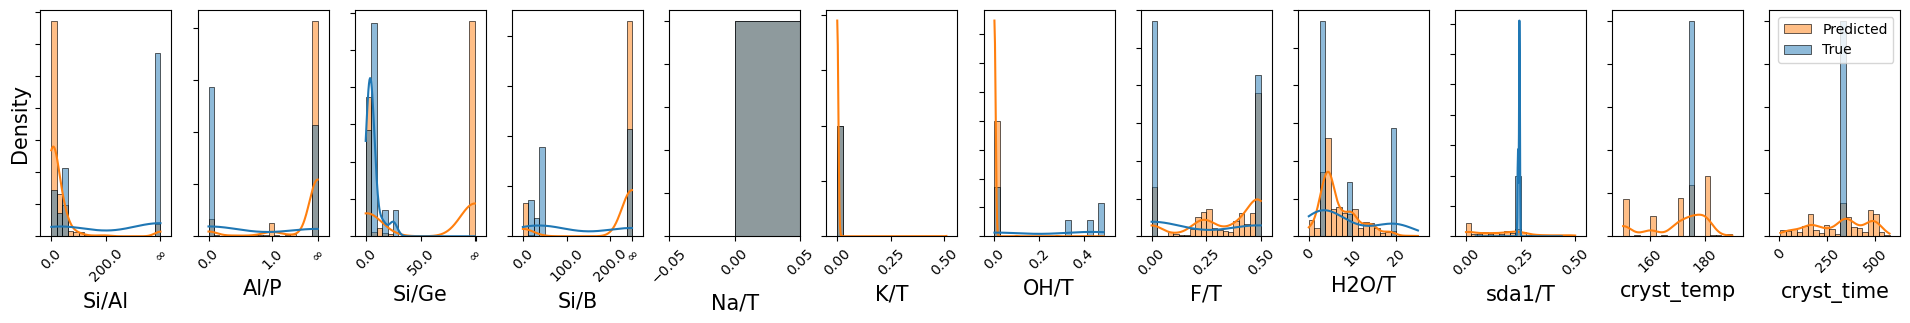

BEC C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


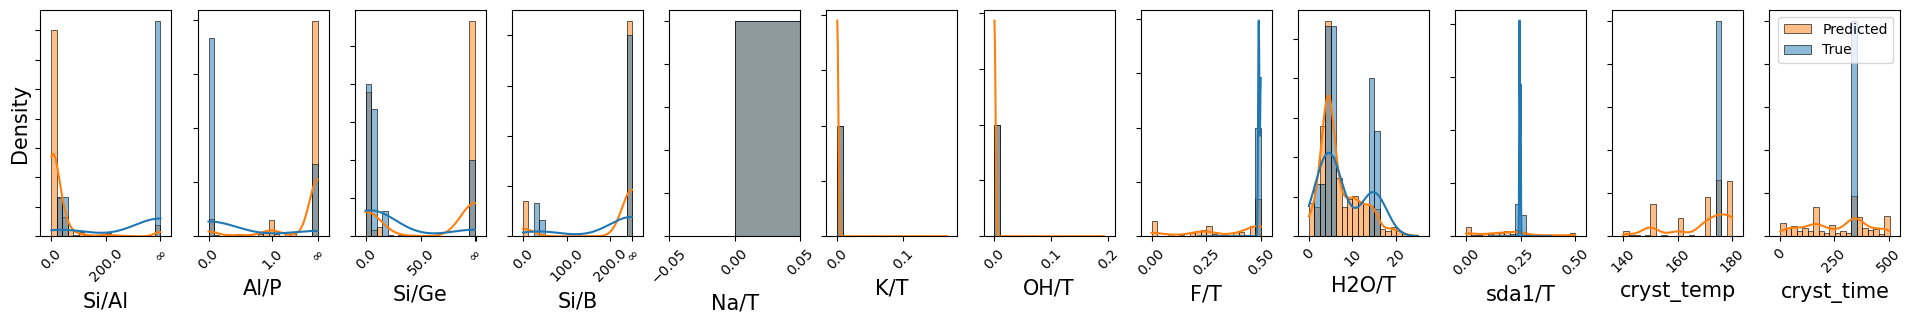

In [9]:
# Check BEC system for Si/Ge and F/T
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in reversed(zeo_osda_systems):
    if zeo == 'BEC':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], ['tab:orange', 'tab:blue'], kde=True, common_norm=True, alpha=0.5)
        
        count += 1
        if count > 50:
            break

In [10]:
sys_syn_pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
4156,0.3,1.717997,99.0,250.000000,0.0,0.0,0.0,0.250000,6.032262,0.157209,175.0,168.000000,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
4157,0.0,1.717997,0.0,250.000000,0.0,0.0,0.0,0.459145,8.333333,0.044828,180.0,334.370148,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
4158,0.0,1.717997,0.0,0.000000,0.0,0.0,0.0,0.400000,1.500000,0.000000,175.0,168.000000,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
4159,100.0,1.717997,99.0,250.000000,0.0,0.0,0.0,0.500000,4.259522,0.333333,170.0,336.000000,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
4160,100.0,1.717997,99.0,250.000000,0.0,0.0,0.0,0.500000,4.600023,0.260015,170.0,311.807983,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257398,400.0,1.717997,99.0,250.000000,0.0,0.0,0.0,0.500000,4.000000,0.294118,170.0,360.000000,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
257399,0.0,1.717997,0.0,0.769488,0.0,0.0,0.0,0.459834,11.363357,0.000000,180.0,336.000000,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
257400,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.480000,7.439834,0.250000,170.0,32.983093,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
257401,10.0,1.717997,99.0,250.000000,0.0,0.0,0.0,0.000000,2.911612,0.249561,145.0,314.215088,BEC,C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31
